# Libs

In [1]:
from ibm_botocore.client import Config
import ibm_boto3

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200208195210-0002
KERNEL_ID = 12d4dacb-ac45-4106-910b-e6c616439389


In [2]:
SEED = 42

# Numpy
import numpy as np
np.random.seed(SEED)

# Pandas
import pandas as pd

# Sklearn

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import cross_validate, learning_curve, train_test_split

# Metrics and tuning
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import svm

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense

# Stats
from scipy import stats

# Vizualization
import seaborn as sns
sns.set(style="whitegrid")

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Using TensorFlow backend.


# Some custom useful functions

In [3]:
def histograms_numeric_columns(df, numerical_columns):
    '''
    Takes df, numerical columns as list
    Returns a group of histagrams
    '''
    f = pd.melt(df, value_vars=numerical_columns) 
    g = sns.FacetGrid(f, col='variable',  col_wrap=4, sharex=False, sharey=False)
    g = g.map(sns.distplot, 'value')
    return g

def heatmap_numeric_w_dependent_variable(df, dependent_variable):
    '''
    Takes df, a dependant variable as str
    Returns a heatmap of all independent variables' correlations with dependent variable 
    '''
    plt.figure(figsize=(8, 10))
    g = sns.heatmap(df.corr()[[dependent_variable]].sort_values(by=dependent_variable), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1) 
    return g

def cramers_v(x, y):
    '''
    Returns cramers_v for 2 categorical features
    '''
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def heatmap_categorical_columns_w_dependant_categorical(df, dependent_variable, columns):
    '''
    Takes df, a dependant variable as str
    Returns a heatmap of catecorical columns cramers_v with dependent variable 
    '''
    plt.figure(figsize=(8, 10))
    corrM = [cramers_v(df[dependent_variable], df[column]) for column in columns]
    corr = pd.DataFrame(corrM, index=columns, columns=[dependent_variable])
    ax = sns.heatmap(corr,
            annot=True,
            cmap='coolwarm', 
            vmin=-1,
            vmax=1,
           )
    ax.set_title("Cramer V Correlation between Variables")
    return ax

# Data

In [4]:
credentials = {
    'IAM_SERVICE_ID': '',
    'IBM_API_KEY_ID': '',
    'ENDPOINT': '',
    'IBM_AUTH_ENDPOINT': '',
    'BUCKET': '',
    'FILE': ''
}

In [5]:
cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])

In [6]:
cos.download_file(Bucket=credentials['BUCKET'],Key='data.csv',Filename='init_copy.csv')

In [7]:
df = pd.read_csv('init_copy.csv')

# ETL

ETL stands for "Extract, Transform, Load"
It is the general procedure of copying data from one or more sources into a destination system which represents the data differently from the source(s) or in a different context than the source(s).

In my case, I work with the data of scientific researches, so there is no need to read sensors data, or something like that.
We already know the structure of our dataset (as it is stable).

But for the purpose of the task, let's assume that we want to deploy our final model as a service.
If that's the case, I suppose it will be great to have some minimal validation of the data, coming from website (for example) to our model.

In [8]:
df.head(1)

,Study ID,Patient ID,Sample ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,...,Oncotree Code,Overall Survival Status,PR Status,Radio Therapy,Number of Samples Per Patient,Sample Type,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,brca_metabric,MB-0000,MB-0000,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,NO,claudin-low,...,IDC,LIVING,Negative,YES,1,Primary,ER-/HER2-,22.0,2.0,1


Let's consider the row above as an example of the data coming to our system. Whether it will be used to retrain our model or to make a prediction - it needs to be transformed. So let's look at what exactly do we need.

# Data Cleansing

First of all, we need to drop unnecessary columns such as:

**ID's**:
1. Study ID - we are not interested in this one
2. Patient ID - we do not need this too (we ensured, that this feature is unique)
3. Sample ID

**Not relevant or doc-information columns**:
1. "Oncotree" Code
2. Cancer type - all the same after dropping 2 rows with Breast Sarcoma - outliers (we want to study only breast cancer cases, also 3 raws are  certainly not enough to study different cancer type in this project)
3. Sample type - they are all the same
4. Number of Samples Per Patient - all the same
5. Cohort - not relevant
6. Overall Survival Status - we use Patient's Vital status instead

In [9]:
df = df.drop(df.loc[df['Cancer Type']=='Breast Sarcoma'].index)

In [10]:
df = df.drop(columns=[
    'Study ID',
    'Sample ID',
    'Patient ID',
    'Oncotree Code',
    'Cancer Type',
    'Sample Type',
    'Number of Samples Per Patient',
    'Cohort',
    'Overall Survival Status',
])

As mentioned in the problem definition, we want to make predictions based only on a patient's initial tests. So, the first thing that we want to exclude from our datasets is future knowledge about patient treatment, not related to initial tests.

Columns deleted:
1. **Chemotherapy** - Future
2. **Hormone Therapy** - Future
3. **Radio Therapy** - Future
4. **Type of Breast Surgery** - Future
5. **Nottingham prognostic index** - is used to determine prognosis following surgery for breast cancer - Future

In [11]:
df = df.drop(columns=['Chemotherapy', 'Hormone Therapy', 'Radio Therapy', 'Type of Breast Surgery', 'Nottingham prognostic index'])

## Missing values

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1914 entries, 0 to 1915
Data columns (total 20 columns):
Age at Diagnosis                  1914 non-null float64
Cancer Type Detailed              1875 non-null object
Cellularity                       1852 non-null object
Pam50 + Claudin-low subtype       1913 non-null object
ER status measured by IHC         1876 non-null object
ER Status                         1914 non-null object
Neoplasm Histologic Grade         1832 non-null float64
HER2 status measured by SNP6      1913 non-null object
HER2 Status                       1913 non-null object
Tumor Other Histologic Subtype    1875 non-null object
Inferred Menopausal State         1913 non-null object
Integrative Cluster               1913 non-null object
Primary Tumor Laterality          1809 non-null object
Lymph nodes examined positive     1844 non-null float64
Mutation Count                    1802 non-null float64
PR Status                         1913 non-null object
3-Gene cl

First of all, let's check how many data we lose if we drop NaN columns:

In [13]:
print(f'{((1-(df.dropna().shape[0])/(df.shape[0]))*100):.2f}% percents')

44.57% percents


Okay, it's obviously not an option. Than, let's start to work on it.

#### Cancer Type Detailed and Tumor Other Histologic Subtype

In [14]:
df['Cancer Type Detailed'].unique()

array(['Breast Invasive Ductal Carcinoma',
       'Breast Mixed Ductal and Lobular Carcinoma',
       'Breast Invasive Lobular Carcinoma', nan,
       'Breast Invasive Mixed Mucinous Carcinoma', 'Breast',
       'Metaplastic Breast Cancer'], dtype=object)

In [15]:
df['Tumor Other Histologic Subtype'].unique()

array(['Ductal/NST', 'Mixed', 'Lobular', 'Tubular/ cribriform', nan,
       'Mucinous', 'Medullary', 'Other', 'Metaplastic'], dtype=object)

All of the types are obviously types of Breast cancer, so the 'Breast' category is something like a NaN category (not detailed type in detailed types), so let's assign all NaN to this category not to create one more. We do the same for 'Tumor Other Histologic Subtype' - assign 'Other' value.

In [16]:
df.fillna({'Cancer Type Detailed': 'Breast', 'Tumor Other Histologic Subtype': 'Other'}, inplace=True)

Now, when we fixed Nan values in these columns, we can check the correlation between them:

In [17]:
cramers_v(df['Cancer Type Detailed'], df['Tumor Other Histologic Subtype'])

0.9994757535681643

In [18]:
df[['Cancer Type Detailed', 'Tumor Other Histologic Subtype']].head(10)

,Cancer Type Detailed,Tumor Other Histologic Subtype
0,Breast Invasive Ductal Carcinoma,Ductal/NST
1,Breast Invasive Ductal Carcinoma,Ductal/NST
2,Breast Invasive Ductal Carcinoma,Ductal/NST
3,Breast Mixed Ductal and Lobular Carcinoma,Mixed
4,Breast Mixed Ductal and Lobular Carcinoma,Mixed
5,Breast Invasive Ductal Carcinoma,Ductal/NST
6,Breast Invasive Ductal Carcinoma,Ductal/NST
7,Breast Invasive Lobular Carcinoma,Lobular
8,Breast Mixed Ductal and Lobular Carcinoma,Mixed
9,Breast Invasive Ductal Carcinoma,Ductal/NST


These two variables are the same - we can drop one of them

In [19]:
df = df.drop(columns=['Cancer Type Detailed'])

#### ER status and ER status measured by IHC

In [20]:
unique_count = 0

for x, raw in df.iterrows():
    if not (pd.isnull(raw['ER status measured by IHC'])):
        if raw['ER status measured by IHC'] != raw['ER Status']:
            if raw['ER status measured by IHC'] == 'Positve' and raw['ER Status'] == 'Positive':
                continue
            unique_count += 1

print(x)
print(f'Percent where statuses differs: {(unique_count/x)*100}')

1915
Percent where statuses differs: 6.527415143603134


On 6.5 percent of patients, these two features differ. There are various opportunities to choose from. We can drop one of these columns due to the high correlation between them. We can fill nan values from the second column due to the first one. We can fill nan values in many other ways. Let's check out the correlation between these features:

In [21]:
cramers_v(df['ER status measured by IHC'], df['ER Status'])

0.8105583899161047

Cramers V is high, but not as in the previous example so we will leave these features for now. But we still need to solve the problem of missing values.

In [22]:
df['ER status measured by IHC'].unique()

array(['Positve', 'Negative', nan], dtype=object)

In [23]:
df['ER Status'].unique()

array(['Positive', 'Negative'], dtype=object)

The simplest way with the correlation this high is to use ER status to fill NaN values of ER status measured by IHC

In [24]:
for idx, raw in df.iterrows():
    if (pd.isnull(raw['ER status measured by IHC'])):
        if raw['ER Status'] == 'Positive':
            df.loc[idx, 'ER status measured by IHC'] = 'Positve'
        else:
            df.loc[idx, 'ER status measured by IHC'] = raw['ER Status']

In [25]:
df['ER status measured by IHC'].unique()

array(['Positve', 'Negative'], dtype=object)

#### Tumor Stage

Tumor Stage is the column with the most values missing, so let's discuss it. As I googled it up, before 2018 Tumor stage was calculated based on just three clinical characteristics, T, N, and M:

1. the size of the cancer tumor and whether or not it has grown into nearby tissue (T) - in our data Tumor size
2. whether cancer is in the lymph nodes (N) - in our data Lymph nodes examined positive (it's even more detailed)
3. whether cancer has spread to other parts of the body beyond the breast (M) - don't have this one (and it seems if it is, it's stage 4, which we have only 10 records)

Source - https://www.breastcancer.org/symptoms/diagnosis/staging 

So it's the column, based on other columns we already got, with a lot of missing values, that possibly will profoundly affect the result. In this particular case, I think dropping this column will be the best choice.
Another way is to use Classification to generate missing values.

Let's check our hypothesis out:

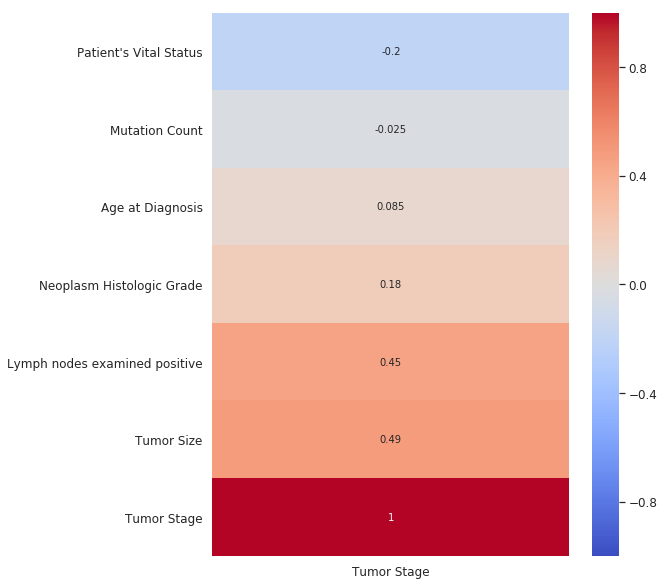

In [26]:
heatmap_numeric_w_dependent_variable(df, 'Tumor Stage')

As we see, Tumor Stage heavily depends on 2 columns (as expected). But, we know, that the stage is was determined by 3 parametres, not 2. So, we can conclude that with dropping this column we will loose a part of the information.

In [27]:
# making a copy of df for further imputation
df_imputed = df.copy(deep=True)

In [28]:
df = df.drop(columns=['Tumor Stage'])

#### 3-Gene classifier subtype 

In [29]:
df['3-Gene classifier subtype'].unique()

array(['ER-/HER2-', 'ER+/HER2- High Prolif', nan, 'ER+/HER2- Low Prolif',
       'HER2+'], dtype=object)

Let's check how this feature correlates with others:

In [30]:
numeric_cols = ['Age at Diagnosis', 'Lymph nodes examined positive','Mutation Count', 'Tumor Size']
categorical_cols = list(set(df.columns.values.tolist()) - set(numeric_cols))

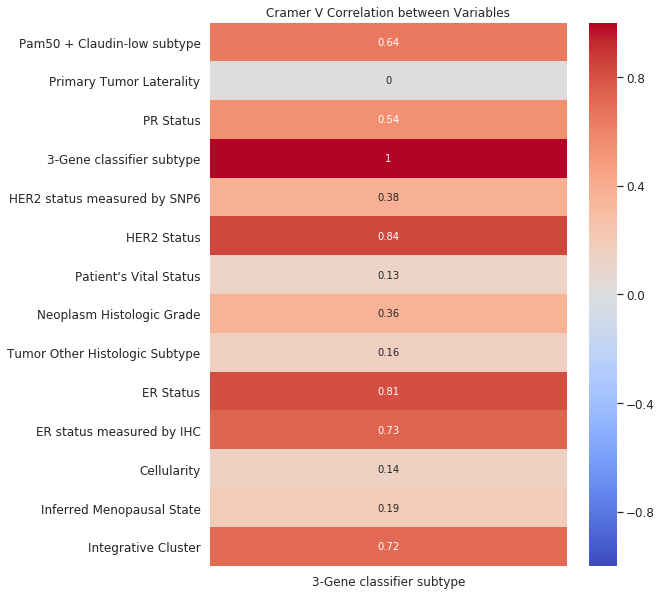

In [31]:
heatmap_categorical_columns_w_dependant_categorical(df, '3-Gene classifier subtype', categorical_cols)

As we can see, it heavily correlates with a lot of other columns in our data - it may be just a combination of them. So let's drop it for now.

In [32]:
df.loc[df['3-Gene classifier subtype'].isnull()==False][['ER Status', 'HER2 Status', '3-Gene classifier subtype',]][:5]

,ER Status,HER2 Status,3-Gene classifier subtype
0,Positive,Negative,ER-/HER2-
1,Positive,Negative,ER+/HER2- High Prolif
4,Positive,Negative,ER+/HER2- High Prolif
5,Positive,Negative,ER+/HER2- High Prolif
7,Negative,Negative,ER-/HER2-


In [33]:
df = df.drop(columns=['3-Gene classifier subtype'])

In [34]:
categorical_cols.remove('3-Gene classifier subtype')

#### Obvious outliers 

In [35]:
 for i in range(5,10):
    print(f'{df[df.isnull().sum(axis=1) > i].shape[0]} strings with {i} Nan')

1 strings with 5 Nan
1 strings with 6 Nan
1 strings with 7 Nan
0 strings with 8 Nan
0 strings with 9 Nan


In [36]:
df = df.drop(df[df.isnull().sum(axis=1) > 5].index)

In [37]:
df.shape

(1913, 17)

In [38]:
 for i in range(5,10):
    print(f'{df_imputed[df_imputed.isnull().sum(axis=1) > i].shape[0]} strings with {i} Nan')

3 strings with 5 Nan
1 strings with 6 Nan
1 strings with 7 Nan
1 strings with 8 Nan
1 strings with 9 Nan


In [39]:
df_imputed = df_imputed.drop(df_imputed[df_imputed.isnull().sum(axis=1) > 5].index)

#### Other NaNs

In [40]:
print(f'df NaNs drop: {df.shape[0]} -> {df.dropna().shape[0]}')

df NaNs drop: 1913 -> 1578


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1913 entries, 0 to 1915
Data columns (total 17 columns):
Age at Diagnosis                  1913 non-null float64
Cellularity                       1852 non-null object
Pam50 + Claudin-low subtype       1913 non-null object
ER status measured by IHC         1913 non-null object
ER Status                         1913 non-null object
Neoplasm Histologic Grade         1831 non-null float64
HER2 status measured by SNP6      1913 non-null object
HER2 Status                       1913 non-null object
Tumor Other Histologic Subtype    1913 non-null object
Inferred Menopausal State         1913 non-null object
Integrative Cluster               1913 non-null object
Primary Tumor Laterality          1809 non-null object
Lymph nodes examined positive     1843 non-null float64
Mutation Count                    1801 non-null float64
PR Status                         1913 non-null object
Tumor Size                        1891 non-null float64
Patient'

#### Primary Tumor Laterality

In [42]:
df['Primary Tumor Laterality'].value_counts()

Left     947
Right    862
Name: Primary Tumor Laterality, dtype: int64

In [43]:
df['Primary Tumor Laterality'].isna().sum()

104

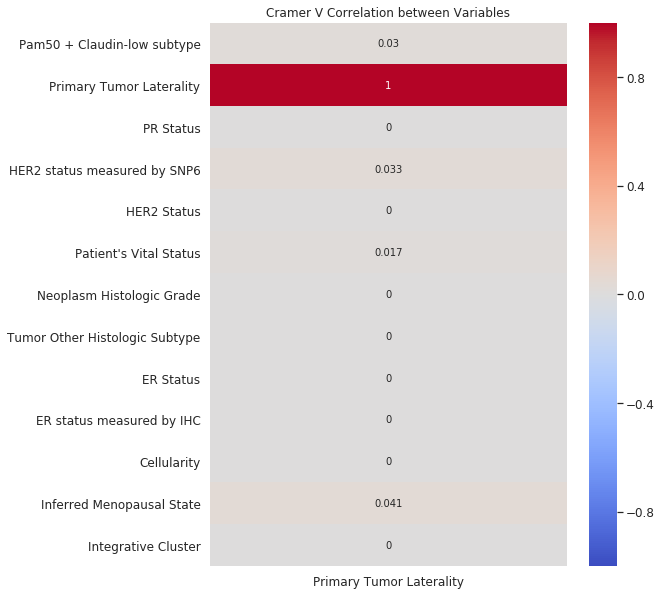

In [44]:
heatmap_categorical_columns_w_dependant_categorical(df, 'Primary Tumor Laterality', categorical_cols)

That's strange. And a good reason to go and google it. And as we can see in research papers:

1. https://www.ncbi.nlm.nih.gov/pubmed/24740002 
2. https://ideas.repec.org/a/plo/pone00/0094815.html

The effect of Primary Tumor Laterality on survival is very doubtful. So, according to almost zero correlation with any other features and according to scientific researches with a much more significant number of patients, we can drop this feature.

In [45]:
df = df.drop(columns=['Primary Tumor Laterality'])

In [46]:
print(f'df NaNs drop: {df.shape[0]} -> {df.dropna().shape[0]}')

df NaNs drop: 1913 -> 1674


At this point I decided to drop Nan's. All features left are pretty important - Mutation Count, Nodes examined e.t.c. And we cant just replace missed values with mean - it will affect our end model too much.


In [47]:
df = df.dropna()

# Guideline checks

## Data types

Are data types of columns matching their content? E.g. is age stored as integer and not as string?

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1674 entries, 1 to 1915
Data columns (total 16 columns):
Age at Diagnosis                  1674 non-null float64
Cellularity                       1674 non-null object
Pam50 + Claudin-low subtype       1674 non-null object
ER status measured by IHC         1674 non-null object
ER Status                         1674 non-null object
Neoplasm Histologic Grade         1674 non-null float64
HER2 status measured by SNP6      1674 non-null object
HER2 Status                       1674 non-null object
Tumor Other Histologic Subtype    1674 non-null object
Inferred Menopausal State         1674 non-null object
Integrative Cluster               1674 non-null object
Lymph nodes examined positive     1674 non-null float64
Mutation Count                    1674 non-null float64
PR Status                         1674 non-null object
Tumor Size                        1674 non-null float64
Patient's Vital Status            1674 non-null int64
dtypes: f

In [49]:
df.head()

,Age at Diagnosis,Cellularity,Pam50 + Claudin-low subtype,ER status measured by IHC,ER Status,Neoplasm Histologic Grade,HER2 status measured by SNP6,HER2 Status,Tumor Other Histologic Subtype,Inferred Menopausal State,Integrative Cluster,Lymph nodes examined positive,Mutation Count,PR Status,Tumor Size,Patient's Vital Status
1,43.19,High,LumA,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,Pre,4ER+,0.0,2.0,Positive,10.0,1
2,48.87,High,LumB,Positve,Positive,2.0,NEUTRAL,Negative,Ductal/NST,Pre,3,1.0,2.0,Positive,15.0,0
3,47.68,Moderate,LumB,Positve,Positive,2.0,NEUTRAL,Negative,Mixed,Pre,9,3.0,1.0,Positive,25.0,1
4,76.97,High,LumB,Positve,Positive,3.0,NEUTRAL,Negative,Mixed,Post,9,8.0,2.0,Positive,40.0,0
5,78.77,Moderate,LumB,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,Post,7,0.0,4.0,Positive,31.0,0


In [50]:
df['Neoplasm Histologic Grade'].unique()

array([3., 2., 1.])

In [51]:
df['Neoplasm Histologic Grade'] = df['Neoplasm Histologic Grade'].astype('category')

## Ranges
Does the value distribution of values in a column make sense? Use stats (e.g. min,
max, mean, standard deviation) and visualizations (e.g. box-plot, histogram) for
help

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a6020c5f8>]],
      dtype=object)

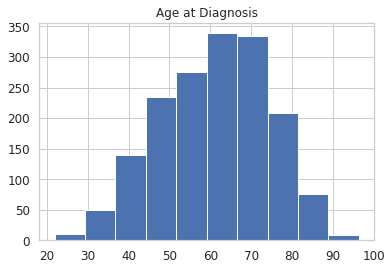

In [52]:
df.hist('Age at Diagnosis')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a60184b38>]],
      dtype=object)

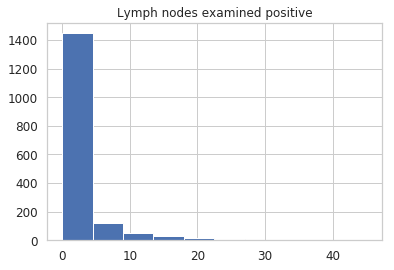

In [53]:
df.hist('Lymph nodes examined positive')

In [54]:
df['Lymph nodes examined positive'].max()

45.0

From google - "The number of axillary lymph nodes can vary from person to person, ranging from five nodes to more than 30."

In [55]:
df.loc[df['Lymph nodes examined positive']>30]

,Age at Diagnosis,Cellularity,Pam50 + Claudin-low subtype,ER status measured by IHC,ER Status,Neoplasm Histologic Grade,HER2 status measured by SNP6,HER2 Status,Tumor Other Histologic Subtype,Inferred Menopausal State,Integrative Cluster,Lymph nodes examined positive,Mutation Count,PR Status,Tumor Size,Patient's Vital Status
226,40.50,High,Her2,Negative,Negative,3.0,GAIN,Positive,Ductal/NST,Pre,5,41.0,7.0,Negative,24.0,0
1628,66.94,High,Her2,Negative,Negative,3.0,GAIN,Positive,Ductal/NST,Post,5,31.0,4.0,Positive,10.0,0
1900,54.42,Moderate,LumB,Positve,Positive,2.0,LOSS,Negative,Lobular,Post,6,33.0,10.0,Negative,30.0,0
1913,62.90,High,LumB,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,Post,1,45.0,4.0,Positive,25.0,0


Seems, there are no mistakes in this feature

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a600ecb00>]],
      dtype=object)

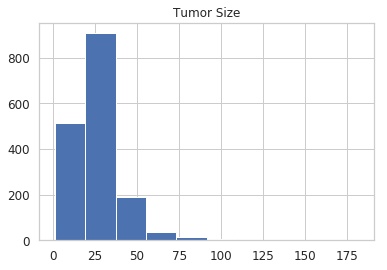

In [56]:
df.hist('Tumor Size')

In [57]:
df.loc[df['Tumor Size']>100]

,Age at Diagnosis,Cellularity,Pam50 + Claudin-low subtype,ER status measured by IHC,ER Status,Neoplasm Histologic Grade,HER2 status measured by SNP6,HER2 Status,Tumor Other Histologic Subtype,Inferred Menopausal State,Integrative Cluster,Lymph nodes examined positive,Mutation Count,PR Status,Tumor Size,Patient's Vital Status
43,83.89,High,LumA,Positve,Positive,3.0,NEUTRAL,Negative,Lobular,Post,3,14.0,8.0,Negative,150.0,0
267,69.32,Moderate,LumB,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,Post,2,17.0,5.0,Negative,180.0,0
456,52.43,High,Her2,Positve,Negative,3.0,GAIN,Negative,Ductal/NST,Post,10,22.0,5.0,Negative,160.0,0
708,38.20,High,LumB,Negative,Positive,3.0,LOSS,Negative,Ductal/NST,Pre,1,6.0,4.0,Positive,130.0,0
1552,58.90,High,Normal,Negative,Negative,3.0,GAIN,Positive,Ductal/NST,Post,5,16.0,2.0,Negative,120.0,0
1825,28.78,High,Basal,Negative,Negative,3.0,NEUTRAL,Negative,Ductal/NST,Pre,10,1.0,7.0,Negative,182.0,1


# Load data to object storage

In [58]:
export_csv = df.to_csv('cleaned_data_2.csv', index = None, header=True)
cos.upload_file(Filename='cleaned_data_2.csv',Bucket=credentials['BUCKET'], Key='cleaned_data_2')

# Feature Imputation 

As a task of week 3, Let's make a feature imputation of some previously dropped features and see, how it will affect our model

## Tumor Stage

I will take all correlated-enough features and will predict tumor stage grade, not to lose valuable information

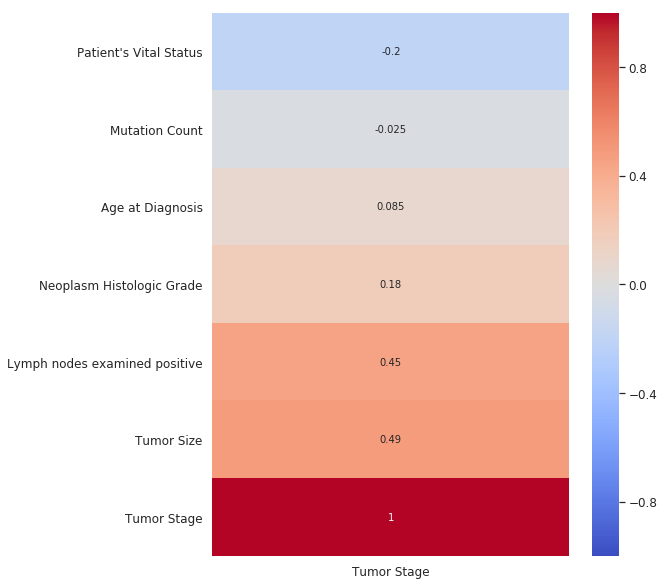

In [59]:
heatmap_numeric_w_dependent_variable(df_imputed, 'Tumor Stage')

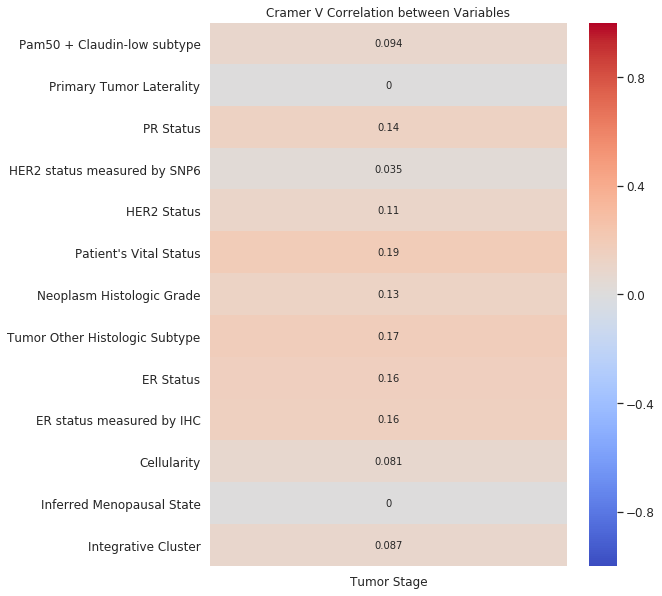

In [60]:
df_imputed['Tumor Stage'] = df_imputed['Tumor Stage'].astype('category')
heatmap_categorical_columns_w_dependant_categorical(df_imputed, 'Tumor Stage', categorical_cols)

In [61]:
df_to_impute_stage = df_imputed.loc(axis=1)['Tumor Stage', 'Lymph nodes examined positive', 'Tumor Size', 'ER Status', 'Tumor Other Histologic Subtype']

In [62]:
df_to_impute_stage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1911 entries, 0 to 1915
Data columns (total 5 columns):
Tumor Stage                       1415 non-null category
Lymph nodes examined positive     1843 non-null float64
Tumor Size                        1890 non-null float64
ER Status                         1911 non-null object
Tumor Other Histologic Subtype    1911 non-null object
dtypes: category(1), float64(2), object(2)
memory usage: 76.7+ KB


There are few samples, we cannot make prognosis for, because of NaN values in most valuable features - Lymph nodes and Tumor Size.

We need to drop them here and in a main dataset too, to avoid further errors.

In [63]:
indexes = df_to_impute_stage[(df_to_impute_stage['Lymph nodes examined positive'].isnull()) | (df_to_impute_stage['Tumor Size'].isnull())].index
df_to_impute_stage = df_to_impute_stage.drop(indexes)
df_imputed = df_imputed.drop(indexes)

Now, we will take all data, where the value of stage is known and will use it to predict all unknown values of this feature for the rest of the data

In [64]:
df_to_impute_stage_train = df_to_impute_stage[df_to_impute_stage['Tumor Stage'].notnull()]
df_to_impute_stage_impute = df_to_impute_stage.loc[df_to_impute_stage['Tumor Stage'].isnull()]

In [65]:
le = LabelEncoder()
labels = df_to_impute_stage_train[['Tumor Stage']]
enc_labels = le.fit_transform(labels)
print(le.classes_)

[0. 1. 2. 3. 4.]


/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [66]:
df_to_impute_stage_train = df_to_impute_stage_train.drop(columns=['Tumor Stage'])
df_to_impute_stage_impute = df_to_impute_stage_impute.drop(columns=['Tumor Stage'])

In [67]:
df_to_impute_stage_train_cat = df_to_impute_stage_train[['ER Status', 'Tumor Other Histologic Subtype']]
df_to_impute_stage_train_num = df_to_impute_stage_train[['Lymph nodes examined positive', 'Tumor Size']]

In [68]:
df_to_impute_stage_impute_cat = df_to_impute_stage_impute[['ER Status', 'Tumor Other Histologic Subtype']]
df_to_impute_stage_impute_num = df_to_impute_stage_impute[['Lymph nodes examined positive', 'Tumor Size']]

In [69]:
scaler = StandardScaler()

In [70]:
df_to_impute_stage_train_num_scaled = scaler.fit_transform(df_to_impute_stage_train_num, enc_labels)
df_to_impute_stage_impute_num_scaled = scaler.transform(df_to_impute_stage_impute_num)

In [71]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

df_to_impute_stage_train_cat_oh = enc.fit_transform(df_to_impute_stage_train_cat)
df_to_impute_stage_impute_cat_oh = enc.transform(df_to_impute_stage_impute_cat)

df_to_impute_stage_train_scaled = np.hstack((df_to_impute_stage_train_num_scaled, df_to_impute_stage_train_cat_oh))
df_to_impute_stage_impute_scaled = np.hstack((df_to_impute_stage_impute_num_scaled, df_to_impute_stage_impute_cat_oh))

rf = RandomForestClassifier(n_estimators = 500, max_depth = 10, random_state = 42)   
rf = rf.fit(df_to_impute_stage_train_scaled, enc_labels)

predicted = rf.predict(df_to_impute_stage_impute_scaled)
predicted_labels = le.inverse_transform(predicted)
df_to_impute_stage_impute['Tumor Stage'] = predicted_labels
df_imputed.loc[df_to_impute_stage_impute.index, 'Tumor Stage'] = df_to_impute_stage_impute['Tumor Stage']

In [72]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1825 entries, 0 to 1915
Data columns (total 19 columns):
Age at Diagnosis                  1825 non-null float64
Cellularity                       1774 non-null object
Pam50 + Claudin-low subtype       1825 non-null object
ER status measured by IHC         1825 non-null object
ER Status                         1825 non-null object
Neoplasm Histologic Grade         1758 non-null float64
HER2 status measured by SNP6      1825 non-null object
HER2 Status                       1825 non-null object
Tumor Other Histologic Subtype    1825 non-null object
Inferred Menopausal State         1825 non-null object
Integrative Cluster               1825 non-null object
Primary Tumor Laterality          1726 non-null object
Lymph nodes examined positive     1825 non-null float64
Mutation Count                    1783 non-null float64
PR Status                         1825 non-null object
3-Gene classifier subtype         1627 non-null object
Tumor Siz

In [73]:
df_imputed['Tumor Stage'] = df_imputed['Tumor Stage'].astype('category')

## 3-Gene classifier subtype

In [74]:
df_imputed['3-Gene classifier subtype'].unique()

array(['ER-/HER2-', 'ER+/HER2- High Prolif', nan, 'ER+/HER2- Low Prolif',
       'HER2+'], dtype=object)

In [75]:
df_imputed['3-Gene classifier subtype'].value_counts()

ER+/HER2- Low Prolif     592
ER+/HER2- High Prolif    579
ER-/HER2-                278
HER2+                    178
Name: 3-Gene classifier subtype, dtype: int64

Let's check if any other column can explain missing data in this one:

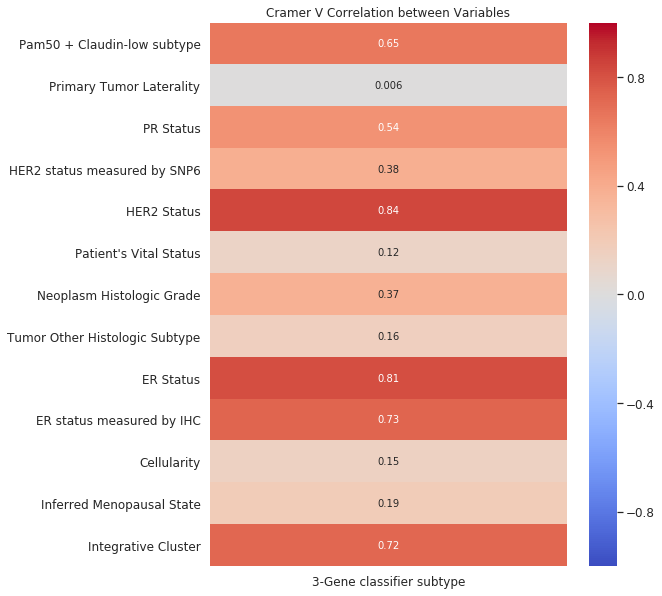

In [76]:
heatmap_categorical_columns_w_dependant_categorical(df_imputed, '3-Gene classifier subtype', categorical_cols)

In [78]:
df_imputed.loc[df_imputed['3-Gene classifier subtype'].isnull()==False][['Integrative Cluster', 'Pam50 + Claudin-low subtype', 'ER Status', 'HER2 Status', '3-Gene classifier subtype']][:5]

,Integrative Cluster,Pam50 + Claudin-low subtype,ER Status,HER2 Status,3-Gene classifier subtype
0,4ER+,claudin-low,Positive,Negative,ER-/HER2-
1,4ER+,LumA,Positive,Negative,ER+/HER2- High Prolif
4,9,LumB,Positive,Negative,ER+/HER2- High Prolif
5,7,LumB,Positive,Negative,ER+/HER2- High Prolif
9,9,LumB,Positive,Negative,ER+/HER2- High Prolif


In [79]:
df_to_impute_gene = df_imputed.loc(axis=1)['Integrative Cluster', 'Pam50 + Claudin-low subtype', 'ER Status', 'ER status measured by IHC', 'HER2 Status', 'HER2 status measured by SNP6', '3-Gene classifier subtype']

In [80]:
df_to_impute_gene.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1825 entries, 0 to 1915
Data columns (total 7 columns):
Integrative Cluster             1825 non-null object
Pam50 + Claudin-low subtype     1825 non-null object
ER Status                       1825 non-null object
ER status measured by IHC       1825 non-null object
HER2 Status                     1825 non-null object
HER2 status measured by SNP6    1825 non-null object
3-Gene classifier subtype       1627 non-null object
dtypes: object(7)
memory usage: 194.1+ KB


In [81]:
df_to_impute_gene.loc[df_to_impute_gene['HER2 Status'].isnull()]

,Integrative Cluster,Pam50 + Claudin-low subtype,ER Status,ER status measured by IHC,HER2 Status,HER2 status measured by SNP6,3-Gene classifier subtype


In [82]:
df_to_impute_gene = df_to_impute_gene.drop(df_to_impute_gene.loc[df_to_impute_gene['HER2 Status'].isnull()].index)

In [83]:
df_to_impute_gene.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1825 entries, 0 to 1915
Data columns (total 7 columns):
Integrative Cluster             1825 non-null object
Pam50 + Claudin-low subtype     1825 non-null object
ER Status                       1825 non-null object
ER status measured by IHC       1825 non-null object
HER2 Status                     1825 non-null object
HER2 status measured by SNP6    1825 non-null object
3-Gene classifier subtype       1627 non-null object
dtypes: object(7)
memory usage: 114.1+ KB


In [84]:
df_imputed = df_imputed.drop(df_to_impute_gene.loc[df_to_impute_gene['HER2 Status'].isnull()].index)

In [85]:
df_to_impute_gene_train = df_to_impute_gene[df_to_impute_gene['3-Gene classifier subtype'].notnull()]
df_to_impute_gene_impute = df_to_impute_gene.loc[df_to_impute_gene['3-Gene classifier subtype'].isnull()]

In [86]:
df_to_impute_gene_train.shape[0]

1627

In [87]:
df_to_impute_gene_impute.shape[0]

198

In [88]:
le = LabelEncoder()
labels = df_to_impute_gene_train[['3-Gene classifier subtype']]
enc_labels = le.fit_transform(labels)
print(le.classes_)

['ER+/HER2- High Prolif' 'ER+/HER2- Low Prolif' 'ER-/HER2-' 'HER2+']


/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [89]:
df_to_impute_gene_train = df_to_impute_gene_train.drop(columns=['3-Gene classifier subtype'])
df_to_impute_gene_impute = df_to_impute_gene_impute.drop(columns=['3-Gene classifier subtype'])

In [90]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
df_to_impute_gene_train_oh = enc.fit_transform(df_to_impute_gene_train)
df_to_impute_gene_impute_oh = enc.transform(df_to_impute_gene_impute)

In [91]:
rf = RandomForestClassifier(n_estimators = 500, max_depth = 10, random_state = 42)   
rf = rf.fit(df_to_impute_gene_train_oh, enc_labels)
predicted = rf.predict(df_to_impute_gene_impute_oh)
predicted_labels = le.inverse_transform(predicted)
df_to_impute_gene_impute['3-Gene classifier subtype'] = predicted_labels

In [92]:
df_to_impute_gene_impute.head(10)

,Integrative Cluster,Pam50 + Claudin-low subtype,ER Status,ER status measured by IHC,HER2 Status,HER2 status measured by SNP6,3-Gene classifier subtype
2,3,LumB,Positive,Positve,Negative,NEUTRAL,ER+/HER2- High Prolif
3,9,LumB,Positive,Positve,Negative,NEUTRAL,ER+/HER2- High Prolif
6,3,LumB,Positive,Positve,Negative,LOSS,ER+/HER2- High Prolif
8,3,claudin-low,Positive,Positve,Negative,NEUTRAL,ER+/HER2- Low Prolif
12,4ER+,LumB,Positive,Positve,Negative,GAIN,ER+/HER2- High Prolif
13,4ER-,claudin-low,Negative,Negative,Negative,NEUTRAL,ER-/HER2-
14,5,LumA,Positive,Positve,Positive,GAIN,HER2+
15,4ER+,claudin-low,Positive,Positve,Positive,GAIN,ER+/HER2- Low Prolif
17,7,LumB,Positive,Positve,Negative,NEUTRAL,ER+/HER2- High Prolif
18,10,LumB,Positive,Positve,Negative,GAIN,ER+/HER2- High Prolif


In [93]:
df_imputed.loc[df_to_impute_gene_impute.index, '3-Gene classifier subtype'] = df_to_impute_gene_impute['3-Gene classifier subtype']

In [94]:
df_imputed.shape

(1825, 19)

## Neoplasm Histological Grade

In [95]:
df_imputed['Neoplasm Histologic Grade'].value_counts()

3.0    893
2.0    710
1.0    155
Name: Neoplasm Histologic Grade, dtype: int64

In [96]:
df_imputed['Neoplasm Histologic Grade'].isna().sum()

67

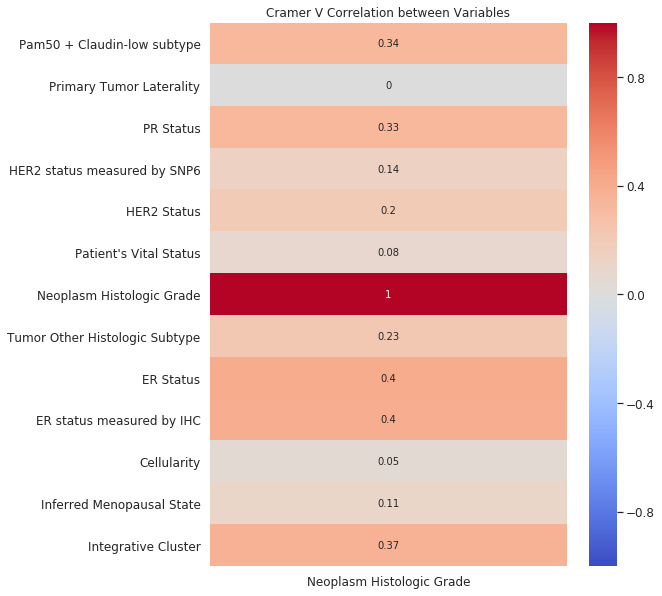

In [97]:
heatmap_categorical_columns_w_dependant_categorical(df_imputed, 'Neoplasm Histologic Grade', categorical_cols)

In [98]:
df_imputed['Neoplasm Histologic Grade'] = df_imputed['Neoplasm Histologic Grade'].astype('float64')

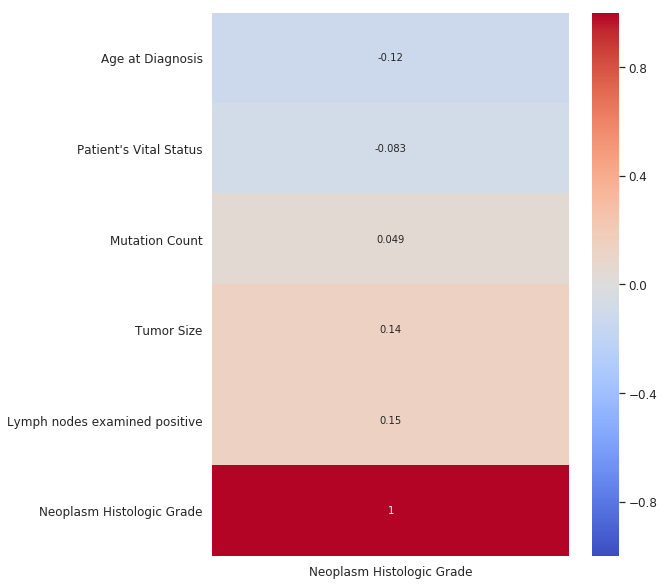

In [99]:
heatmap_numeric_w_dependent_variable(df_imputed, 'Neoplasm Histologic Grade')

In [100]:
df_imputed['Neoplasm Histologic Grade'] = df_imputed['Neoplasm Histologic Grade'].astype('category')

In [101]:
df_to_impute_nhg = df_imputed.loc(axis=1)[
    'Integrative Cluster',
    'Pam50 + Claudin-low subtype',
    'ER Status',
    'Tumor Other Histologic Subtype',
    '3-Gene classifier subtype',
    'PR Status',
    'Neoplasm Histologic Grade',
]

In [102]:
df_to_impute_nhg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1825 entries, 0 to 1915
Data columns (total 7 columns):
Integrative Cluster               1825 non-null object
Pam50 + Claudin-low subtype       1825 non-null object
ER Status                         1825 non-null object
Tumor Other Histologic Subtype    1825 non-null object
3-Gene classifier subtype         1825 non-null object
PR Status                         1825 non-null object
Neoplasm Histologic Grade         1758 non-null category
dtypes: category(1), object(6)
memory usage: 181.7+ KB


In [103]:
df_to_impute_nhg_train = df_to_impute_nhg[df_to_impute_nhg['Neoplasm Histologic Grade'].notnull()]
df_to_impute_nhg_impute = df_to_impute_nhg.loc[df_to_impute_nhg['Neoplasm Histologic Grade'].isnull()]

In [104]:
le = LabelEncoder()
labels = df_to_impute_nhg_train[['Neoplasm Histologic Grade']]
enc_labels = le.fit_transform(labels)
print(le.classes_)

[1. 2. 3.]


/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [105]:
df_to_impute_nhg_train = df_to_impute_nhg_train.drop(columns=['Neoplasm Histologic Grade'])
df_to_impute_nhg_impute = df_to_impute_nhg_impute.drop(columns=['Neoplasm Histologic Grade'])

In [106]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
df_to_impute_nhg_train_oh = enc.fit_transform(df_to_impute_nhg_train)
df_to_impute_nhg_impute_oh = enc.transform(df_to_impute_nhg_impute)

In [107]:
rf = RandomForestClassifier(n_estimators = 500, max_depth = 10, random_state = 42)   
rf = rf.fit(df_to_impute_nhg_train_oh, enc_labels)

In [108]:
predicted = rf.predict(df_to_impute_nhg_impute_oh)
predicted_labels = le.inverse_transform(predicted)
df_to_impute_nhg_impute['Neoplasm Histologic Grade'] = predicted_labels
df_imputed.loc[df_to_impute_nhg_impute.index, 'Neoplasm Histologic Grade'] = df_to_impute_nhg_impute['Neoplasm Histologic Grade']

In [109]:
df_to_impute_nhg_impute.head(10)

,Integrative Cluster,Pam50 + Claudin-low subtype,ER Status,Tumor Other Histologic Subtype,3-Gene classifier subtype,PR Status,Neoplasm Histologic Grade
123,4ER+,claudin-low,Positive,Lobular,ER+/HER2- Low Prolif,Positive,2.0
130,5,Her2,Negative,Ductal/NST,HER2+,Negative,3.0
133,8,LumB,Positive,Mixed,ER+/HER2- High Prolif,Positive,2.0
142,3,LumA,Positive,Lobular,ER+/HER2- Low Prolif,Negative,2.0
151,3,LumA,Positive,Ductal/NST,ER+/HER2- Low Prolif,Positive,2.0
154,7,LumA,Positive,Mixed,ER+/HER2- Low Prolif,Positive,2.0
157,8,LumA,Positive,Mixed,ER+/HER2- Low Prolif,Positive,2.0
197,4ER-,Normal,Negative,Other,ER-/HER2-,Negative,2.0
382,8,LumA,Positive,Ductal/NST,ER+/HER2- Low Prolif,Positive,2.0
452,4ER+,Normal,Positive,Other,ER+/HER2- Low Prolif,Positive,3.0


In [110]:
df_imputed['Neoplasm Histologic Grade'].value_counts()

3.0    914
2.0    756
1.0    155
Name: Neoplasm Histologic Grade, dtype: int64

In [111]:
df_imputed['Neoplasm Histologic Grade'].isna().sum()

0

## Cecullarity

The number and type of cells in a given tissue

In [112]:
df_imputed['Cellularity'].value_counts()

High        907
Moderate    679
Low         188
Name: Cellularity, dtype: int64

In [113]:
df_imputed['Cellularity'].isna().sum()

51

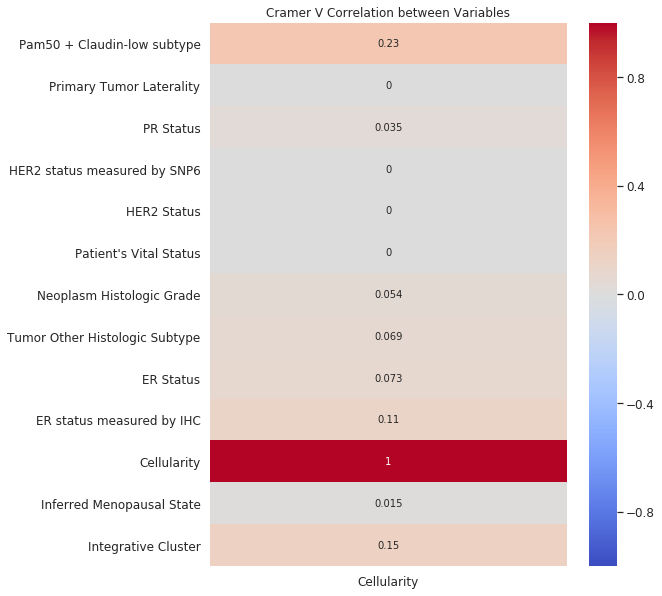

In [114]:
heatmap_categorical_columns_w_dependant_categorical(df_imputed, 'Cellularity', categorical_cols)

There is no correlations with other features - so we got two options - either drop NaN values, or create new category for missing values. I prefer second one. So let's do it in our datasets

In [115]:
df_imputed['Cellularity'] = df_imputed['Cellularity'].astype('category')
df_imputed['Cellularity'] = df_imputed['Cellularity'].cat.add_categories(['Undefined'])
df_imputed['Cellularity'] = df_imputed['Cellularity'].fillna('Undefined')

In [116]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1825 entries, 0 to 1915
Data columns (total 19 columns):
Age at Diagnosis                  1825 non-null float64
Cellularity                       1825 non-null category
Pam50 + Claudin-low subtype       1825 non-null object
ER status measured by IHC         1825 non-null object
ER Status                         1825 non-null object
Neoplasm Histologic Grade         1825 non-null category
HER2 status measured by SNP6      1825 non-null object
HER2 Status                       1825 non-null object
Tumor Other Histologic Subtype    1825 non-null object
Inferred Menopausal State         1825 non-null object
Integrative Cluster               1825 non-null object
Primary Tumor Laterality          1726 non-null object
Lymph nodes examined positive     1825 non-null float64
Mutation Count                    1783 non-null float64
PR Status                         1825 non-null object
3-Gene classifier subtype         1825 non-null object
Tumor 

## Primary Tumor Laterality

In [117]:
df_imputed = df_imputed.drop(columns=['Primary Tumor Laterality'])

## Mutation Count

In [118]:
df_imputed['Mutation Count'].isna().sum()

42

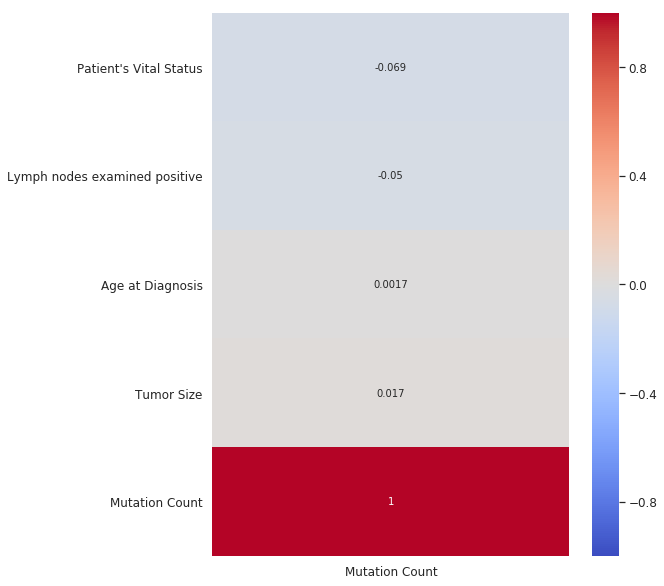

In [119]:
heatmap_numeric_w_dependent_variable(df_imputed, 'Mutation Count')

In [120]:
df_imputed.drop(columns=['Mutation Count'], inplace=True)

# Result

In [121]:
df.shape

(1674, 16)

In [122]:
df_imputed.shape

(1825, 17)

In [123]:
export_csv = df_imputed.to_csv('imputed_data.csv', index = None, header=True)
cos.upload_file(Filename='imputed_data.csv', Bucket=credentials['BUCKET'], Key='imputed_data')